# Network Modeling

In this notebook, I will use computational techniques for studying properties of networks. These techniques will involve both the study of real world networks as well as computational simulation/modeling techniques.

## Prerequisites
I will be assuming some minimal knowledge of graph theory and familiarity with Python. If you know what directed/undirected graphs are, you should be fine. Otherwise, take a few minutes to read the wikipedia page <a href = "https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)">here</a>.

## Objectives
<ul>
<li> Learn how to construct/manipulate network representations of real world data </li>
<li> Obtain practical experience using NetworkX and other modeling techniques for graphs </li>
<li> Learn how to simulate dynamical systems on networks </li>
</ul>

## Software & Packages
You should have the following installed. If you've installed the package manager anaconda, the following packages should be taken care of for you: numpy, scipy, networkx.

You will however need to independently install lighting (`pip install lightning-python`) and plot.ly, which you should be able to install via conda or pip (`conda install plotly`).

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline
from helpers import FileIO
graph = FileIO.read_dolphins();

All we've done so far is import the necessary libraries and read in the graph. Before we do any actual computation however, it's a good idea to visualize the data set.

We'll be using the fairly standard `matplotlib.pyplot` module for visualization. If you want to see documentation about how to use the library, here is the <a href = "http://matplotlib.org/api/pyplot_summary.html"> documentation</a>. 

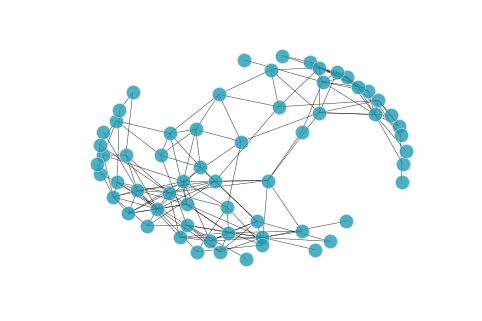

In [42]:
nx.draw_spring(graph, node_color='#209BB2', alpha = 0.8, node_size = 200, width = 0.5);

So now we've seen what the community looks like. Now let's examine some basic properties of the network. NetworkX already has most analytics built in, so we don't need to write much code to describe this network.

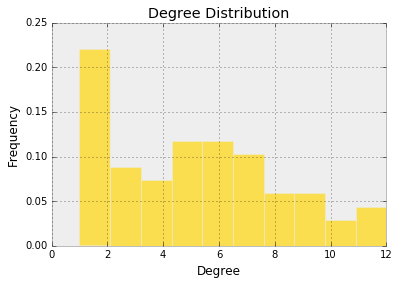

In [7]:
fig = plt.figure(); ax = fig.add_subplot(111); ax.set_xlabel('Degree'); 
ax.set_ylabel('Frequency'); ax.set_title('Degree Distribution');
ax.hist((nx.degree(graph)).values(), color = '#FFDA29', alpha = 0.8, align = 'mid', normed=True);

So we can see that the degree of the vertices varies from 1-12 with most vertices having small degree. But which ones are these? We can visualize the graph again, but specify attributes for the nodes to see which ones have large degree.

In [37]:
degrees = nx.degree(graph);
nx.set_node_attributes(graph, 'degree', degrees);

Drawing is a little more involved now, but not by much more.

In [35]:
pos = nx.spring_layout(graph);
nodelist = range(1, nx.number_of_nodes(graph)+1);
degree_nodes = [float(graph.node[node]['degree'])/12.0 for node in nodelist]

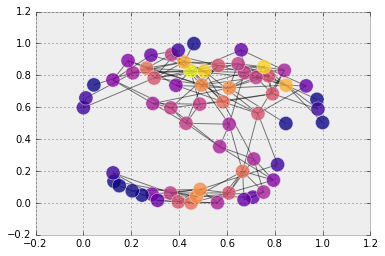

In [36]:
nx.draw_networkx_nodes(graph,pos, nodelist=nodelist, node_color=degree_nodes, node_size=200, 
                       cmap=plt.cm.plasma, alpha = 0.8)
nx.draw_networkx_edges(graph,pos,width=1.0,alpha=0.5)


We can do something similar for any node attribute we want to visualize. Suppose we want to determine the nodes that rank high for "in-betweeness." This is a metric that calculates the proportion of vertex pairs shortest paths that use node $v$ as a hub.

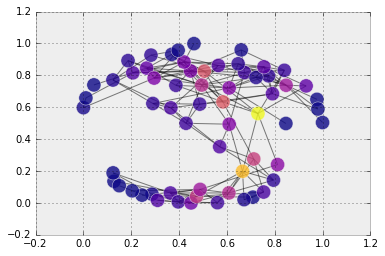

In [43]:
betweeness = nx.betweenness_centrality(graph);
bb_data = [float(betweeness[node]) for node in nodelist];
nx.draw_networkx_nodes(graph, pos, nodelist=nodelist, node_color=bb_data, node_size=200, 
                       cmap=plt.cm.plasma, alpha = 0.8)
nx.draw_networkx_edges(graph,pos,width=1.0,alpha=0.5)

In the next stage, we're going to compute the random walk centrality. A node has high centrality with this method if a large proportion of random walks between vertices use that node.


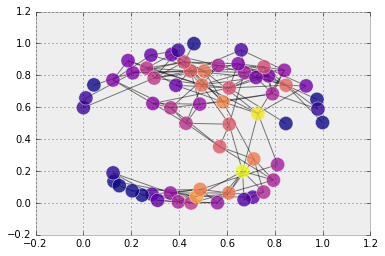

In [44]:
rw_cent = nx.current_flow_betweenness_centrality(graph);
rw_centrality = [float(rw_cent[node]) for node in nodelist];
nx.draw_networkx_nodes(graph, pos, nodelist=nodelist, node_color=rw_centrality, node_size=200, 
                       cmap=plt.cm.plasma, alpha = 0.8)
nx.draw_networkx_edges(graph,pos,width=1.0,alpha=0.5)

It turns out that because of this network structure, both "betweeness" metrics give similar results.

## Network Dynamics
In this section, we'll turn our attention to simulating dynamical systems on networks. Dynamical systems loosely refer to systems that deal with processes over time. While the canonical example is a system of differential equations, we can also have discrete dynamical systems, which is what we'll be working with today.

We're going to first define a simulation class that will take in a function for applying a network rule. This will allow us to construct a general simulation class that can model a variety of different dynamical system models, including epidemic modeling, voter agreement circles, and clustering rules.

Some code was taken from <i>Modeling and Analysis of Complex Systems</i>, which you can download for free <a href= "http://textbooks.opensuny.org/introduction-to-the-modeling-and-analysis-of-complex-systems/"> here</a>.

In [6]:
import random as rd
class Simulator:
    #will maintain a graph to keep track of current state
    # and another copy for the next state - this is to avoid confusing updates
    def __init__(self, g):
        self.graph = g.copy();
        self.next_graph = g.copy();
    
    def _simulate_step(self, update_func):
        pass
        

class SimulatorAsync:
    '''init_func should be a function such that init_func: node -> [0, 1]
        g is a graph
    '''
    def __init__(self, g, init_func, update_func):
        self.graph = g.copy();
        self.update_func = update_func
        self.pos = nx.spring_layout(graph);
        nx.draw_networkx_nodes(graph, self.pos, nodelist=[g.nodes()], 
                               node_color=[init_func(i, self.graph) for i in g.node_iter()], 
                               node_size=200, cmap=plt.cm.plasma, alpha = 0.8)
        nx.draw_networkx_edges(graph,self.pos,width=1.0,alpha=0.8)
    
    '''_simulate_step is a helper function that runs an asynchronous local update
        on a randomly selected vertex
    '''
    def _simulate_step(self):
        #select random vertex:
        node = rd.choice(self.graph.nodes());
        nodelist = self.update_func(node, self.graph);
        nx.draw_networkx_nodes(self.graph, self.pos, nodelist=nodelist, 
                               node_color=[self.graph.node[i]['state'] for i in nodelist], 
                               node_size=200, 
                               cmap=plt.cm.plasma, alpha = 0.8)
    

In [7]:
import random as rd
''' an indicator variable that returns 1 with probability prob'''
def indicator(prob):
    if (rd.random() <= prob):
        return 1
    else:
        return 0;

'''Epidemic model class'''
class Epidemic:
    @staticmethod
    def randomized_infectation(prob):
        def init_func(i, graph):
            graph.node[i]['state'] = indicator(prob);
        return init_func;
    
    @staticmethod
    def randomized_update(transmission_prob, return_prob):
        def update_func(i, graph):
            updatedlist = [];
            if graph.node[i]['state'] == 1:
                graph.node[i]['state'] = indicator(1-return_prob);
            if graph.node[i]['state'] == 0:
                return [i];
            for j in graph.neighbors(i):
                if graph.node[j]['state'] = 
    
    

SyntaxError: invalid syntax (<ipython-input-7-c23aa5ecf39a>, line 26)